### Synthetic Data Creation with GANs - Porsche Class

In [4]:
!pip install torch

  Using cached torch-2.2.1-cp39-cp39-manylinux1_x86_64.whl (755.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached typing_extensions-4.10.0-py3-none-any.whl (33 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached triton-2.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (167.9 MB)
  Using cached fsspec-2024.3.1-py3-none-any.whl (171 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-man

In [9]:
!pip install torchvision
!pip install matplotlib
!pip install tqdm

  Using cached matplotlib-3.8.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached contourpy-1.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (310 kB)
  Using cached kiwisolver-1.4.5-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.50.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)


In [24]:
!pip install pandas
!pip install numpy

In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torchvision.transforms as tt
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
%matplotlib inline
from torchvision.utils import save_image
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import time

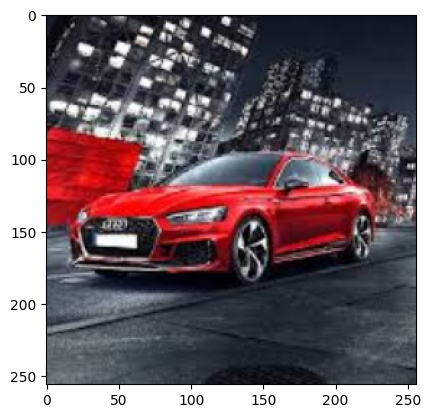

In [96]:
# Synthetic data with DCGan : https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
data_path = "./cars_data_10" # made a separate folder with porsche images to produce porsche synthetic data
image_size = 256
batch_size = 64
normstats = (0.,0.,0.),(1.,1.,1.)
transforms = tt.Compose([tt.Resize(image_size),#resize to make things uniform
                        tt.CenterCrop(image_size),#cropping to the center to avoid distortion
                        tt.ToTensor(),#to a tensor
                        tt.Normalize(*normstats)#normalizing in order to increase effectiveness of our GAN
                        ])
dataset = ImageFolder(data_path, transform = transforms)
img, _ = dataset[0]
plt.imshow(img.permute((1,2,0)))

In [97]:
import torchvision.transforms.functional as F

def denorm(img_tensors):
    return img_tensors * normstats[1][0] + normstats[0][0]

def show_batch(dl):
    for img, _ in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        images = torch.cat([img[i] for i in range(len(img))], dim=2)
        images = F.to_pil_image(denorm(images))
        ax.imshow(images)
        break

def show_images(images):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(denorm(images.detach()[:64]), nrow=8).permute(1, 2, 0))

dataload = DataLoader(dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)
show_batch(dataload)


In [98]:
# GPU or CPU?
def find_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device('cpu')
    
device = find_default_device()
device

device(type='cuda')

In [99]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    else:
        return data.to(device, non_blocking=True)

In [100]:
class DataloaderDeviced():
    def __init__(self,data,device):
        self.data = data
        self.device = device
    def __iter__(self):
        for b in self.data:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.data)

In [101]:
dataload = DataloaderDeviced(dataload,device)

In [102]:
dataload

In [103]:
# Making Descriminator
descriminator = nn.Sequential(
    #input size being of 3 channels, 256x256
    nn.Conv2d(3, 32 ,kernel_size = 3, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.1, inplace=True),
    #output size being of 32 channels, 128x128
    
    nn.Conv2d(32,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1, inplace=True),
    #out 64x64x64
    
    nn.Conv2d(64,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.1, inplace = True),
    #out 128x32x32
    
    nn.Conv2d(128,256,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.1,inplace = True),
    #out 256x16x16
    
    nn.Conv2d(256,512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.1, inplace = True),
    #out 512x8x8
    
    nn.Conv2d(512,1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.1,inplace = True),
    #out 1024x4x4
    
    nn.Conv2d(1024,1,kernel_size = 4,stride = 1, padding = 0, bias = False),
    #out 1x1x1
    
    nn.Flatten(),
    nn.Sigmoid(),
    #final activation for T/F
)

#descriminator.load_state_dict(torch.load("../input/weights/discweights4.pth"))
descriminator = to_device(descriminator,device)
descriminator

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1, inplace=True)
  (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.1, inplace=True)
  (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.1, inplace=True)
  (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.1, inplace=True)
  (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  

In [104]:
# Making a Generator
latent_sz = 128
generator = nn.Sequential(
    #latent in 128x1x1
    nn.ConvTranspose2d(128,1024,kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.1, inplace=True),
    #out 1024x4x4
    
    nn.ConvTranspose2d(1024,512,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.1, inplace=True),
    #out 512x8x8
    
    nn.ConvTranspose2d(512,256,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.1, inplace=True),
    #out 256x16x16
    
    nn.ConvTranspose2d(256,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.1, inplace=True),
    #out 128x32x32
    
    nn.ConvTranspose2d(128,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1, inplace=True),
    #out 64x64x64
    
    nn.ConvTranspose2d(64,32,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.1, inplace=True),
    #out 32x128x128
    
    nn.ConvTranspose2d(32,3,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
    #out 3x256x256
    
)
#generator.load_state_dict(torch.load("../input/weights/genweights4.pth"))
generator

Sequential(
  (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1, inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.1, inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.1, inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.1, inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


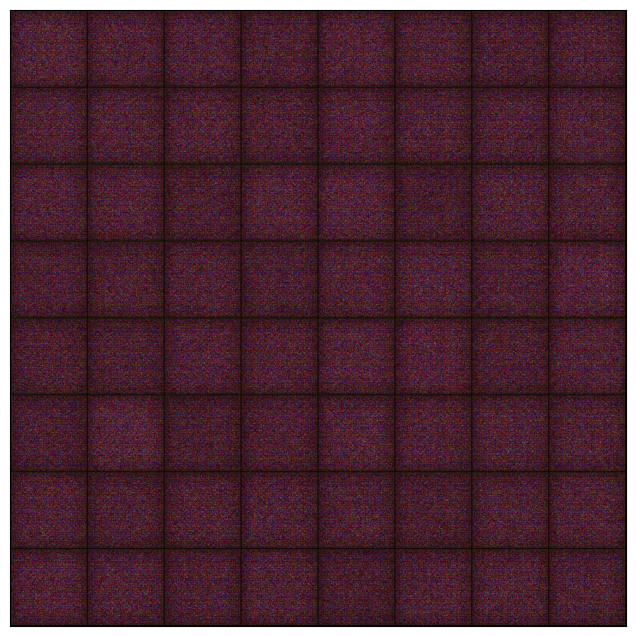

In [105]:
xb = torch.randn(batch_size,latent_sz,1,1,)
fake_images = generator(xb)
show_images(fake_images)
generator = to_device(generator,device)

In [106]:
# Training the discriminator
import torch.nn.functional as F
def train_discriminator(real_images,opt_d):
    
    opt_d.zero_grad()
    real_preds = descriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device = device)
    real_loss = F.binary_cross_entropy(real_preds,real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size,latent_sz,1,1, device = device)
    fake_images = generator(latent)
    
    fake_preds = descriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0),1,device = device)
    fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    loss = fake_loss+real_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(),real_score,fake_score

In [107]:
def train_generator(opt_g):
    opt_g.zero_grad()
    latent = torch.randn(batch_size,latent_sz, 1,1, device = device)
    images = generator(latent)
    
    targets = torch.ones(batch_size,1,device = device)
    score = descriminator(images)
    loss = F.binary_cross_entropy(score,targets)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [109]:
# Saving the generator images
import os
savedir = "gen"
os.makedirs(savedir, exist_ok = True)


In [110]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}e1.png'.format(index+90)
    save_image(denorm(fake_images), os.path.join(savedir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [111]:
torch.manual_seed(64)
fixed_latent = torch.randn(batch_size, latent_sz, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0090e1.png


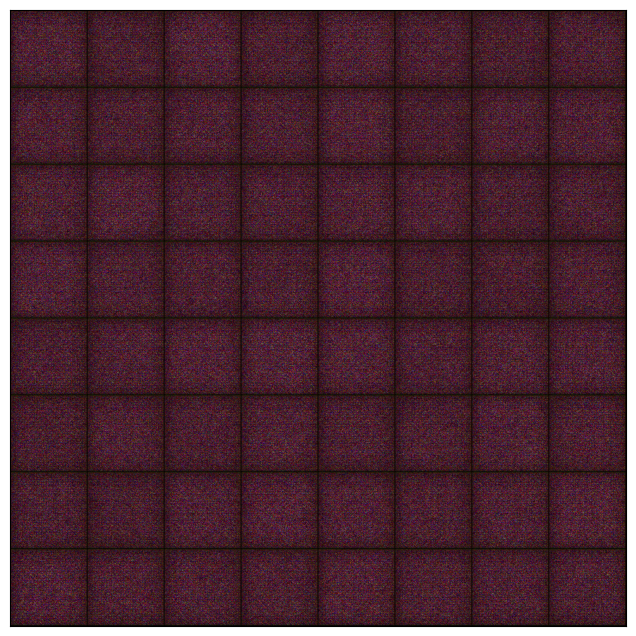

In [112]:
save_samples(0,fixed_latent)

In [113]:
# Fitting the data
def fit(epochs, lr, start_idx = 1):
    loss_d =[]
    loss_g = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(descriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for img, _ in tqdm(dataload):
            
            loss, real_score, fake_score = train_discriminator(img, opt_d)
            lossg = train_generator(opt_g)
            
        loss_d.append(loss)
        loss_g.append(lossg)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss, lossg, real_score, fake_score))
        
        save_samples(epoch+start_idx, fixed_latent, show=False)
        
    return loss_g,loss_d,real_scores,fake_scores

In [114]:
%%time
lr = 5e-4
epochs = 50
history = fit(epochs,lr)

  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/50], loss_g: 2.4132, loss_d: 8.6935, real_score: 0.9618, fake_score: 0.8403
Saving generated-images-0091e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/50], loss_g: 0.5411, loss_d: 8.5652, real_score: 0.9766, fake_score: 0.3332
Saving generated-images-0092e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/50], loss_g: 0.0077, loss_d: 5.6260, real_score: 0.9981, fake_score: 0.0058
Saving generated-images-0093e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/50], loss_g: 0.0033, loss_d: 8.5747, real_score: 0.9974, fake_score: 0.0007
Saving generated-images-0094e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/50], loss_g: 10.5955, loss_d: 6.5264, real_score: 0.0027, fake_score: 0.0007
Saving generated-images-0095e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6/50], loss_g: 0.4799, loss_d: 2.5985, real_score: 0.8732, fake_score: 0.2644
Saving generated-images-0096e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/50], loss_g: 0.2342, loss_d: 4.6796, real_score: 0.9369, fake_score: 0.1317
Saving generated-images-0097e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8/50], loss_g: 0.0693, loss_d: 6.1201, real_score: 0.9934, fake_score: 0.0599
Saving generated-images-0098e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9/50], loss_g: 0.0054, loss_d: 7.4842, real_score: 0.9975, fake_score: 0.0029
Saving generated-images-0099e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/50], loss_g: 0.3206, loss_d: 13.0294, real_score: 0.9938, fake_score: 0.2436
Saving generated-images-0100e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [11/50], loss_g: 0.0068, loss_d: 5.9052, real_score: 0.9991, fake_score: 0.0059
Saving generated-images-0101e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [12/50], loss_g: 0.0004, loss_d: 15.7350, real_score: 0.9996, fake_score: 0.0000
Saving generated-images-0102e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [13/50], loss_g: 5.7754, loss_d: 0.7617, real_score: 0.2687, fake_score: 0.2189
Saving generated-images-0103e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [14/50], loss_g: 0.0189, loss_d: 9.2963, real_score: 0.9932, fake_score: 0.0112
Saving generated-images-0104e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [15/50], loss_g: 4.5231, loss_d: 8.1980, real_score: 0.9984, fake_score: 0.9408
Saving generated-images-0105e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [16/50], loss_g: 0.4987, loss_d: 5.1439, real_score: 0.8950, fake_score: 0.2877
Saving generated-images-0106e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [17/50], loss_g: 0.8327, loss_d: 1.6322, real_score: 0.5157, fake_score: 0.0751
Saving generated-images-0107e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [18/50], loss_g: 0.9420, loss_d: 1.1948, real_score: 0.6950, fake_score: 0.3195
Saving generated-images-0108e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [19/50], loss_g: 0.5985, loss_d: 1.6570, real_score: 0.6833, fake_score: 0.1382
Saving generated-images-0109e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [20/50], loss_g: 0.8949, loss_d: 2.5476, real_score: 0.8205, fake_score: 0.4219
Saving generated-images-0110e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [21/50], loss_g: 0.6039, loss_d: 2.8400, real_score: 0.8017, fake_score: 0.2110
Saving generated-images-0111e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [22/50], loss_g: 1.3428, loss_d: 2.0065, real_score: 0.3687, fake_score: 0.1318
Saving generated-images-0112e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [23/50], loss_g: 0.4596, loss_d: 2.6092, real_score: 0.7958, fake_score: 0.1755
Saving generated-images-0113e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [24/50], loss_g: 0.3894, loss_d: 1.6826, real_score: 0.8604, fake_score: 0.1205
Saving generated-images-0114e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [25/50], loss_g: 0.3515, loss_d: 2.4837, real_score: 0.9062, fake_score: 0.1661
Saving generated-images-0115e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [26/50], loss_g: 0.4829, loss_d: 3.9720, real_score: 0.8548, fake_score: 0.2463
Saving generated-images-0116e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [27/50], loss_g: 0.5414, loss_d: 5.9387, real_score: 0.9769, fake_score: 0.3489
Saving generated-images-0117e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [28/50], loss_g: 0.6923, loss_d: 3.4201, real_score: 0.8672, fake_score: 0.3510
Saving generated-images-0118e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [29/50], loss_g: 1.7176, loss_d: 3.7392, real_score: 0.2473, fake_score: 0.0081
Saving generated-images-0119e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [30/50], loss_g: 0.9668, loss_d: 6.6555, real_score: 0.9310, fake_score: 0.5141
Saving generated-images-0120e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [31/50], loss_g: 1.6727, loss_d: 4.0520, real_score: 0.2654, fake_score: 0.0029
Saving generated-images-0121e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [32/50], loss_g: 0.4998, loss_d: 2.9669, real_score: 0.7676, fake_score: 0.1428
Saving generated-images-0122e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [33/50], loss_g: 0.2758, loss_d: 3.5596, real_score: 0.9283, fake_score: 0.1648
Saving generated-images-0123e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [34/50], loss_g: 0.8864, loss_d: 2.5347, real_score: 0.6015, fake_score: 0.1911
Saving generated-images-0124e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [35/50], loss_g: 0.5030, loss_d: 5.1817, real_score: 0.9015, fake_score: 0.2871
Saving generated-images-0125e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [36/50], loss_g: 0.7809, loss_d: 5.4258, real_score: 0.8637, fake_score: 0.4024
Saving generated-images-0126e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [37/50], loss_g: 0.4057, loss_d: 2.5955, real_score: 0.7668, fake_score: 0.0617
Saving generated-images-0127e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [38/50], loss_g: 1.4718, loss_d: 2.1027, real_score: 0.3174, fake_score: 0.0069
Saving generated-images-0128e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [39/50], loss_g: 0.3980, loss_d: 3.3287, real_score: 0.9296, fake_score: 0.2363
Saving generated-images-0129e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [40/50], loss_g: 1.6950, loss_d: 2.4012, real_score: 0.2805, fake_score: 0.0013
Saving generated-images-0130e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [41/50], loss_g: 0.4690, loss_d: 1.5322, real_score: 0.8078, fake_score: 0.0978
Saving generated-images-0131e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [42/50], loss_g: 0.3275, loss_d: 4.3631, real_score: 0.9398, fake_score: 0.1953
Saving generated-images-0132e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [43/50], loss_g: 0.4206, loss_d: 2.3946, real_score: 0.9973, fake_score: 0.2411
Saving generated-images-0133e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [44/50], loss_g: 0.3892, loss_d: 6.1041, real_score: 0.9334, fake_score: 0.2288
Saving generated-images-0134e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [45/50], loss_g: 0.2743, loss_d: 4.5701, real_score: 0.8375, fake_score: 0.0404
Saving generated-images-0135e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [46/50], loss_g: 0.7887, loss_d: 5.8721, real_score: 0.5914, fake_score: 0.0016
Saving generated-images-0136e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [47/50], loss_g: 1.5487, loss_d: 12.1074, real_score: 0.9886, fake_score: 0.6746
Saving generated-images-0137e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [48/50], loss_g: 0.3640, loss_d: 4.4906, real_score: 0.9948, fake_score: 0.2116
Saving generated-images-0138e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [49/50], loss_g: 2.2090, loss_d: 14.6733, real_score: 0.9995, fake_score: 0.7947
Saving generated-images-0139e1.png


  0%|          | 0/88 [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [50/50], loss_g: 0.3953, loss_d: 3.4478, real_score: 0.7996, fake_score: 0.1189
Saving generated-images-0140e1.png
CPU times: user 26min 40s, sys: 15min 51s, total: 42min 32s
Wall time: 41min 48s


In [118]:
#Visualizing our generator image
torch.manual_seed(94)
latent_test = torch.randn(1,latent_sz,1,1,device=device)
image = generator(latent_test)

In [119]:
image=to_device(image, torch.device("cpu"))
b=image[0].permute(1,2,0).detach().numpy()
b.shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


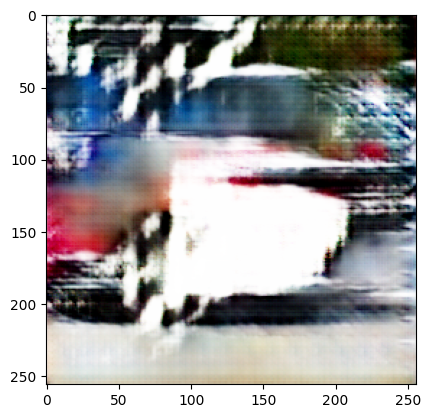

In [120]:
plt.imshow(b)